### Predictor musical

El objetivo de este proyecto es implementar una red neuronal que nos permita ingresar un archivo de audio y predecir cual es su genero. Para ello utilizamos la base de datos GTZAN Dataset compuesta por los siguientes archivos:
* CSV: Contiene dos csv con observaciones de canciones, clasificadas por genero musical.
* genres_original: En esta base tenemos diferentes archivos de audio, con 10 generos diferentes y 100 canciones con una duración de 30 segundos cada una.
* images_original: Contiene espectogramas en un formato de imagen, de cada canción de las bases mencionadas anteriormente.

Al igual responder las preguntas ¿qué diferencía una canción de otra? ¿cómo podemos visualizar el sonido?

In [1]:
# Importamos las librerias a utilizar en el proyecto
%matplotlib inline

import os
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image


import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder, MinMaxScaler

import soundfile as sf
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torchvision.io import read_image
import torchaudio
from PIL import Image
import matplotlib.pyplot as plt

# tqdm es para mostrar una barra de progreso 
from tqdm import tqdm 

# Definimos el dispositivo que se usara
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print("Device: ", device)

Device:  cpu


In [ ]:
# En caso de no tener las librerias anteriores, descomentar las siguiente lineas
# pip install librosa
# pip install matplotlib
# pip install seaborn
# pip install sklearn
# pip install pandas
# pip install numpy

##### Análisis inicial de datos
Comenzamos la exploración de los datos con las bases en formato csv con observaciones de 3 y 30 segundos de ellas. La base se encuentra compuesta por las siguientes variables:
* Caracteristicas de dominio temporal: : Estas características se calculan directamente a partir de la forma de onda de la señal de audio, contiene medidas estadisticas como la media y la desviación estandar.
* Caracteristicas de dominio frecuencial:
* Caracteristicas estadísticas: Un ejemplo de este tipo de medidas son la media, desviacion estandar y curtosis de la señal de audio.
* Caracteristicas frecuenciales: Relacionadas con la tonalidad, complejidad espectral y planitud. Con el termino, "espectro" como la representación de una señal en términos de su contenido de frecuencia. 

In [2]:
# Cargamos la bases y las visualizamos
csv_features_30_sec = 'Data/features_30_sec.csv'
pd.read_csv(csv_features_30_sec)

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [3]:
csv_features_3_sec = 'Data/features_3_sec.csv'
pd.read_csv(csv_features_3_sec)

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [4]:
# Extraemos los nombres de los generos que queremos clasificar
general_path = 'Data'
print(list(os.listdir(f'{general_path}/genres_original/')))

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


Para el proyecto utilizaremos la libreria librosa, esta paqueteria nos permitirá leer un archivo de audio y codificarlo como una serie de tiempo, así como permitirnos obtener el número de muestras de audio transportadas por segundo, medido en Hz o kHz.

In [5]:
y,sr = librosa.load(f'{general_path}/genres_original/rock/rock.00021.wav')
print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')
print('Len of Audio:', 661794/22050)

y: [0.06521606 0.0954895  0.08926392 ... 0.10720825 0.20050049 0.1416626 ] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Len of Audio: 30.013333333333332


In [6]:
#Aplicamos la función trim de librosa, con el fin de cortar el silencio inicial y final del audio
audio_file, _ = librosa.effects.trim(y)
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0.06521606 0.0954895  0.08926392 ... 0.10720825 0.20050049 0.1416626 ] 

Audio File shape: (661794,)


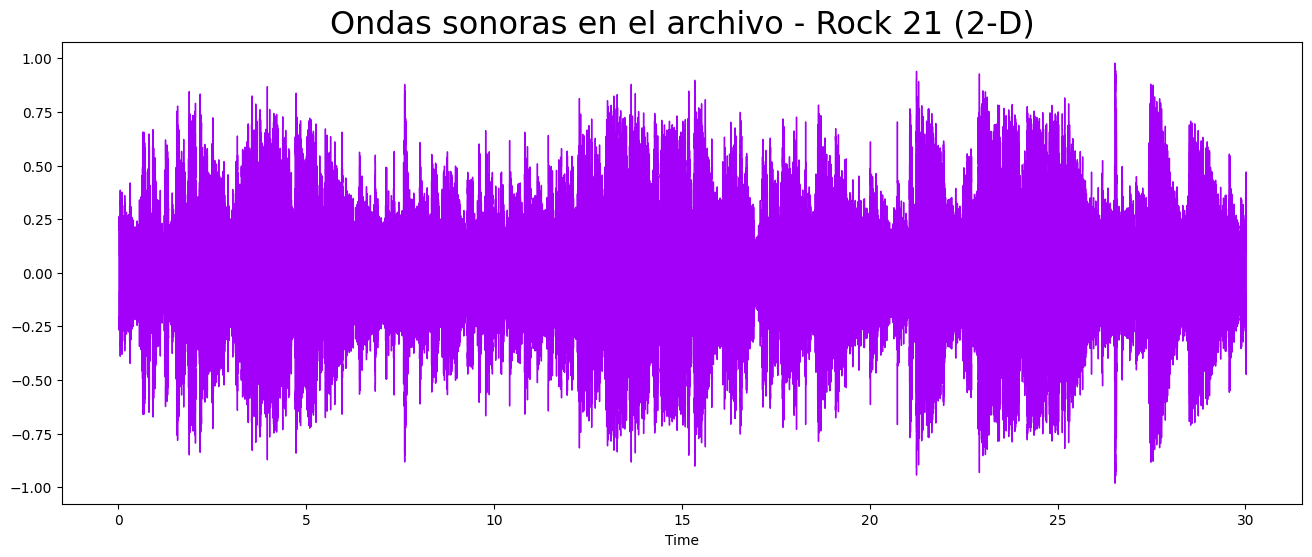

In [7]:
# Graficamos las ondas sonoras del audio elegido
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "#A300F9");
plt.title("Ondas sonoras en el archivo - Rock 21 (2-D)", fontsize = 23);

Shape of D object: (1025, 1293)


Text(0.5, 1.0, 'Log-Frequency Power Spectrogram (dB)')

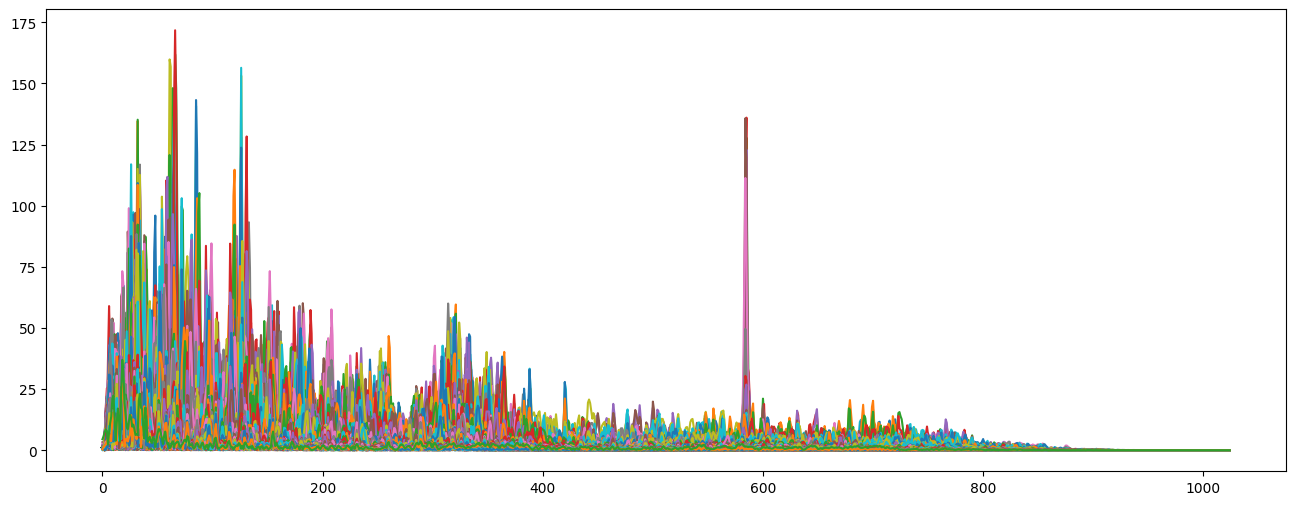

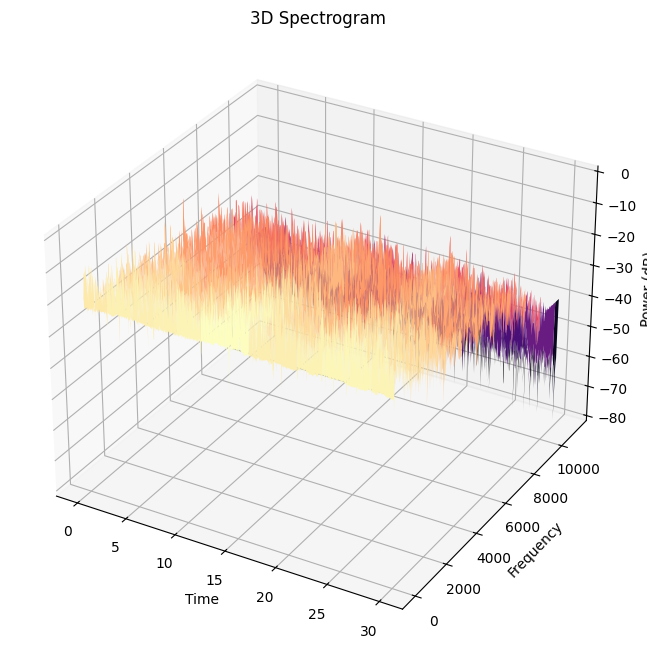

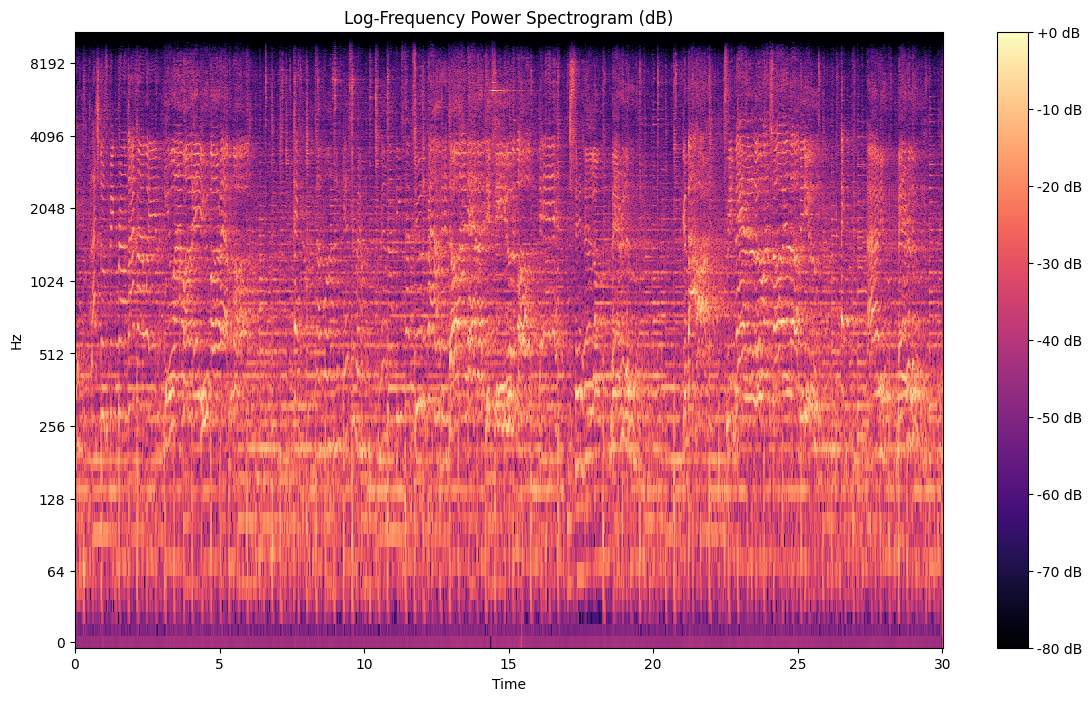

In [8]:
n_fft = 2048
hop_length = 512 # audio de los frames entre las columnas STFT 

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))
print('Shape of D object:', np.shape(D))
plt.figure(figsize = (16, 6))
plt.plot(D);


# Figura 3D
plt.figure(figsize=(12, 8))
X, Y = np.meshgrid(np.linspace(0, audio_file.shape[-1]/sr, num=D.shape[1]), np.linspace(0, 0.5 * sr, num=D.shape[0]))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, librosa.power_to_db(D, ref=np.max), rstride=100, cstride=100, cmap='magma')
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_zlabel('Power (dB)')
plt.title('3D Spectrogram')

# Espectograma
plt.figure(figsize=(14, 8))
librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length), ref=np.max), sr=sr, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Frequency Power Spectrogram (dB)')

In [12]:
Audio('Data/genres_original/rock/rock.00021.wav')

## **RNN-LSTM**

In [9]:
# Definimos nuestra red lstm

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [10]:
# Movemos la direccion del Data-Set a otra Variable
data_path = 'Data/genres_original'

#muestras_por_audio = 661500
muestras_por_audio = 660000

# Numero de los Mel Frequency Cepstral Coefcients (MFCC)
n_mfcc = 13

# Inicializamos la transformada rapida de Fourier (Fast Fourier Transform)
n_fft = 2048

# Definimos el numero de ejemplares entre frames
hop_length = 512

# Definimos el numero de segmentos 
n_segments = 1

# Definimos los ejemplares por segmento
ejemplares_por_segmento = int(muestras_por_audio / n_segments)

# Calculamos el numero de vectores MFFC por segmento
n_mfcc_por_segmento = int(np.ceil(ejemplares_por_segmento / hop_length))


# Definimos la hash table donde vamos a guardar los datos
datos = {
    'filename': [],
    'label': [],
    'mfcc': []
}

# Definimos la funcion que nos va a permitir extraer los datos de los archivos de audio y guardarlos en la hash table de datos
def extraer_datos(genero, genero_id):
    genero_dir = os.path.join(data_path, genero)
    for filename in os.listdir(genero_dir):
        if filename == 'jazz.00054.wav':  # If agregado para saltar este archivo por que nos da un error: Format not recognised
            continue
        songname = os.path.join(genero_dir, filename)
        y, sr = librosa.load(songname, mono=True, duration=30)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        datos['filename'].append(songname)
        datos['label'].append(genero_id)
        datos['mfcc'].append(mfcc.T.tolist())

# Extraer datos de todas las canciones y generos
for i, genero in enumerate(os.listdir(data_path)):
    extraer_datos(genero, i)

# Encontrar la longitud máxima de las secuencias
max_length = max([len(mfcc) for mfcc in datos['mfcc']])
print(f"Max length: {max_length}")

# Función para rellenar las secuencias MFCC
def pad_mfccs(mfcc_list, max_length):
    padded_mfccs = []
    for mfcc in mfcc_list:
        # Rellenar la secuencia MFCC con ceros hasta la longitud máxima
        padding = torch.zeros((max_length - len(mfcc), n_mfcc))
        padded_mfcc = torch.cat((torch.tensor(mfcc), padding), dim=0)
        padded_mfccs.append(padded_mfcc)
    return torch.stack(padded_mfccs)

X = pad_mfccs(datos['mfcc'], max_length)
y = torch.tensor(datos['label']).long()

Max length: 1292


In [11]:
# Definimos los datos que usaremos como entrenamiento y cuales como prueba
def data_Train_Test(X, y, test_size, val_size):
    X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=(val_size + test_size), random_state=42)
    X_validation, X_test, y_validation, y_test = train_test_split(X_remaining, y_remaining, test_size=(test_size / (test_size + val_size)), random_state=42)
    return X_train, X_validation, X_test, y_train, y_validation, y_test

# Dividir los datos utilizando las secuencias rellenadas
X_train, X_validation, X_test, y_train, y_validation, y_test = data_Train_Test(X, y, 0.7, 0.2)

print("Shapes of the datasets:")
print("X_train:", X_train.shape)
print("X_validation:", X_validation.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_validation:", y_validation.shape)
print("y_test:", y_test.shape)

Shapes of the datasets:
X_train: torch.Size([99, 1292, 13])
X_validation: torch.Size([200, 1292, 13])
X_test: torch.Size([700, 1292, 13])
y_train: torch.Size([99])
y_validation: torch.Size([200])
y_test: torch.Size([700])


## **CNN**

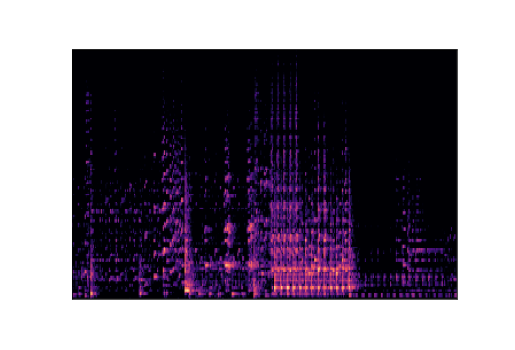

In [52]:
import os 
# Establecemos la ruta que seguiremos
data_images = 'Data/images_original'
spectogram_dataset = []
genre_target = []

# Extraemos la direccion de cada imagen, así como 
# su genero en dos listas
for root, dirs, files in os.walk(data_images):
    for name in files:
        filename = os.path.join(root, name)
        spectogram_dataset.append(filename)
        filename = filename.split("/")[1]
        genre_target.append(filename.split("\\")[1])

# Le asignamos un nivel a cada uno de los generos de musica
genres={'pop': 9,'classical':5,'reggae':2,'disco':0,'jazz':6,'metal':1,'country':8,'blues':3,'hiphop':7,'rock':4}
genre_id = [genres[item] for item in genre_target]

# Basandonos en la ruta de los archivos que tenemos en 
# el data set de los espectrogramas, viasualizamos las imagenes
image_path = spectogram_dataset[500]
image = Image.open(image_path)
# En este caso solo una
plt.imshow(image)
plt.axis('off')
plt.show()

In [53]:
# Tenemos la misma cantidad muestras por genero, por ello, podemos realizar
# un muestreo aleatorio simple de la base de datos
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(spectogram_dataset, genre_id, test_size=0.2, random_state=42)
X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(X_train_img, y_train_img, test_size=0.25, random_state=42)

# Creamos una clase para poder manejar mejor las bases
class MusicDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def sizzze(self):
        return len(self.X)
    
    def get_something(self, idx):
        sample = read_image(self.X[idx])
        label = torch.tensor(self.y[idx])
        return sample, label
    
train_img = MusicDataset(X_train_img, y_train_img)
val_img = MusicDataset(X_val_img, y_val_img)
test_img = MusicDataset(X_test_img, y_test_img)

# Convertimos a DataLoader
batch_size = 36
train_loader_images = DataLoader(train_img, batch_size=batch_size, shuffle=True)
val_loader_images = DataLoader(val_img, batch_size=batch_size, shuffle=False)
test_loader_images = DataLoader(test_img, batch_size=batch_size, shuffle=False)

In [ ]:
class CNN(nn.Module ):
    def __init__( self , num_classes ):
        super( CNN , self ).__init__()
        self.conv1 = nn.Conv2d(in_channels=128 , out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels= 512, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels= 32, out_channels= 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(512* 4 * 6, 256)
        self.fc2 = nn.Linear(256 , 64)
        self.fc3 = nn.Linear(64 , num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu =nn.ReLU()
         
    def forward(self,X):
        out = self.conv1(X)
        out = self.pool(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.pool(out)
        out = self.relu(out) 
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out   

    def train(self,dataloader,epochs,device):
        self.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            outputs = self(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item() * inputs.size(0)
            
        epoch_loss = running_loss / len(dataloader.dataset)
        return epoch_loss